## Acquire a Triggered Signal


Wrote trigger treshold:  16138  counts
Trigger status:  5
Pointer at trigger:  9093


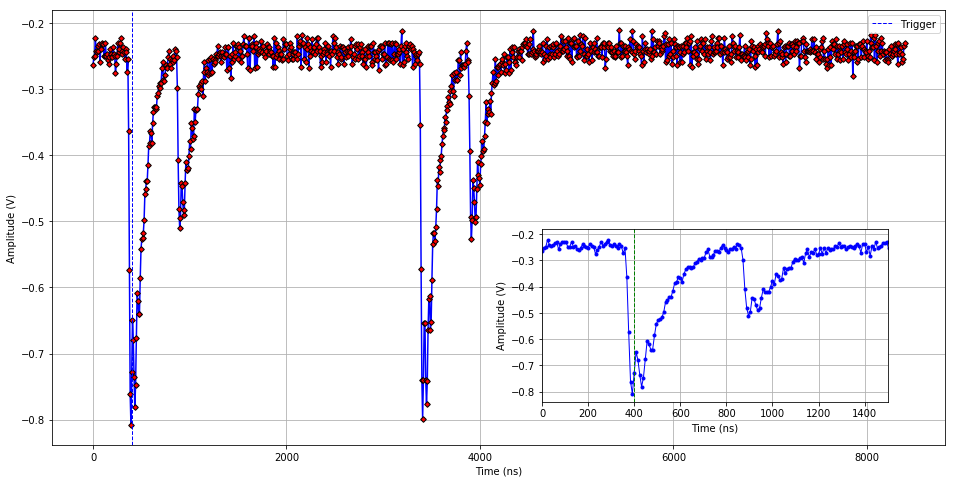

In [11]:
#!/usr/bin/python
###################################inputs
CHANNEL = 1 # 1 
Trigger = -.6 # Volts 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
###################################
from periphery import MMIO
import numpy as np
if (Trigger > GAIN): Trigger = GAIN
if (Trigger < -GAIN): Trigger = -GAIN
if (Trigger>=0):
    counts = int(np.round((Trigger/GAIN)*2**13)-1)
else:
    counts = int(np.round((1+Trigger/GAIN)*2**13)+2**13) 

regset = MMIO(0x40100000, 0x5F)
regset.write16(0x4,3) # trigger source Ch A neg edge
regset.write32(0x8,counts) # Trigger treshold
#regset.write32(0x58,0) # Number of decimated data after trigger written into memory
regset.write32(0x14,1) # decimation
regset.write32(0x10,8000) # Number of decimated data after trigger written into memory
print("Wrote trigger treshold: ",counts, " counts")

regset.write32(0x0,1) # arm trigger

while(1):
    val = regset.read16(0)
    #print(val,end=" ")
    if val > 1:  
        print("Trigger status: ",val)
        break
ptr_at_trigger = regset.read32(0x1C)
print("Pointer at trigger: ",ptr_at_trigger)
regset = MMIO(0x40110000, 0x1FFFC-0x10000)
dat = []
for i in range(0,16300*4,4):
    counts = regset.read32(i)
    if (counts < 2**13):
        DATA_VOLT = GAIN*(counts+1)/2**13 
    if (counts >= 2**13):
        DATA_VOLT =  GAIN*((counts-2**13)/2**13 -1)
    dat.append(DATA_VOLT)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat[ptr_at_trigger-50:ptr_at_trigger+1000]
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = 50*8, color='b', ls='--', lw=1, label='Trigger')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
left, bottom, width, height = [0.55, 0.2, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(x,y,color='b', ls='-', lw=1,marker =".")
ax2.axvline(x = 50*8, color='g', ls='--', lw=1)
ax2.set_xlim([0,1500])
ax2.grid()
ax2.set_xlabel("Time (ns)")
ax2.set_ylabel("Amplitude (V)")
plt.show()
regset.close()